In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
import os
import sqlite3
from typing import List, Union
from typing import Optional

import numpy as np
import tensorflow as tf
from matplotlib.axes import Axes
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from lab import util
from lab.experiment import experiment_run
from lab.lab import Lab


def get_lab():
    return Lab(os.getcwd())


def get_run_info(experiment_name: str, run_index: Optional[int] = None):
    lab = get_lab()
    experiment_path = lab.experiments / experiment_name
    if run_index is None:
        run_index = experiment_run.get_last_run_index(experiment_path, None, False)
    run_path = experiment_path / str(run_index)
    run_info_path = run_path / 'run.yaml'

    with open(str(run_info_path), 'r') as f:
        data = util.yaml_load(f.read())
        run = experiment_run.RunInfo.from_dict(experiment_path, data)

    return run


class Dir:
    def __init__(self, options):
        self.__options = {k.replace('.', '_'): v for k, v in options.items()}
        self.__list = [k for k in self.__options.keys()]

    def __dir__(self):
        return self.__list

    def __getattr__(self, k):
        return self.__options[k]


class TensorBoardAnalyzer:
    def __init__(self, log_path):
        self.event_acc = EventAccumulator(str(log_path))

    def load(self):
        self.event_acc.Reload()

    def tensor(self, name):
        name = name.replace('.', '/')
        return self.event_acc.Tensors(name)

    @staticmethod
    def summarize(events):
        step = np.mean([e.step for e in events])
        values = np.sort([tf.make_ndarray(e.tensor_proto) for e in events])
        basis_points = np.percentile(values, [
            0,
            6.68,
            15.87,
            30.85,
            50.00,
            69.15,
            84.13,
            93.32,
            100.00
        ])

        return np.concatenate(([step], basis_points))

    def summarize_scalars(self, events):
        # Shrink to 100 histograms
        interval = max(1, len(events) // 100)

        merged = []
        results = []
        for i, e in enumerate(events):
            if i > 0 and (i + 1) % interval == 0:
                results.append(self.summarize(merged))
                merged = []
            merged.append(e)
        if len(merged) > 0:
            results.append(self.summarize(merged))

        return np.array(results)

    @staticmethod
    def summarize_compressed_histogram(events):
        basis_points = [
            0,
            668,
            1587,
            3085,
            5000,
            6915,
            8413,
            9332,
            10000
        ]
        results = []
        for e in events:
            assert (len(e.compressed_histogram_values) == len(basis_points))
            for i, c in enumerate(e.compressed_histogram_values):
                assert (c.basis_point == basis_points[i])
            results.append([e.step] + [c.value for c in e.compressed_histogram_values])

        return np.asarray(results)

    @staticmethod
    def render_density(ax: Axes, data, color, name, *,
                       levels=5,
                       line_width=1,
                       alpha=0.6):
        # Mean line
        ln = ax.plot(data[:, 0], data[:, 5],
                     lw=line_width,
                     color=color,
                     alpha=1,
                     label=name)

        # Other percentiles
        for i in range(1, levels):
            ax.fill_between(
                data[:, 0],
                data[:, 5 - i],
                data[:, 5 + i],
                color=color,
                lw=0,
                alpha=alpha ** i)

        return ln

    def render_scalar(self, name, ax: Axes, color, *, levels=5, line_width=1, alpha=0.6):
        data = self.summarize_scalars(self.tensor(name))
        self.render_density(ax, data, color, name,
                            levels=levels,
                            line_width=line_width,
                            alpha=alpha)

    def render_histogram(self, name, ax: Axes, color, *, levels=5, line_width=1, alpha=0.6):
        data = self.summarize_compressed_histogram(self.histogram(name))
        self.render_density(ax, data, color, name,
                            levels=levels,
                            line_width=line_width,
                            alpha=alpha)

    @staticmethod
    def render_matrix(matrix, ax, color):
        from matplotlib.patches import Rectangle
        from matplotlib.collections import PatchCollection

        rows, cols = matrix.shape
        x_ticks = [matrix[0, i] for i in range(1, cols)]
        y_ticks = [matrix[i, 0] for i in range(1, rows)]

        max_density = 0
        for y in range(rows - 2):
            for x in range(cols - 2):
                area = (x_ticks[x + 1] - x_ticks[x]) * (y_ticks[y + 1] - y_ticks[y])
                density = matrix[y + 1, x + 1] / area
                if max_density < density:
                    max_density = density

        boxes = []
        for y in range(rows - 2):
            for x in range(cols - 2):
                width = x_ticks[x + 1] - x_ticks[x]
                height = y_ticks[y + 1] - y_ticks[y]
                area = width * height
                density = matrix[y + 1, x + 1] / area
                density = max(density, 1)
                # alpha = np.log(density) / np.log(max_density)
                alpha = density / max_density
                rect = Rectangle((x_ticks[x], y_ticks[y]), width, height,
                                 alpha=alpha, color=color)
                boxes.append(rect)

        pc = PatchCollection(boxes, match_original=True)

        ax.add_collection(pc)

        # Plot something
        _ = ax.errorbar([], [], xerr=[], yerr=[],
                        fmt='None', ecolor='k')

        return x_ticks[0], x_ticks[-1], y_ticks[0], y_ticks[-1]

    def render_tensors(self, tensors: Union[str, List[any]], axes: np.ndarray, color):
        if type(tensors) == str:
            tensors = self.tensor(tensors)
        assert len(axes.shape) == 2
        assert axes.shape[0] * axes.shape[1] == len(tensors)
        x_min = x_max = y_min = y_max = 0

        for i in range(axes.shape[0]):
            for j in range(axes.shape[1]):
                idx = i * axes.shape[1] + j
                axes[i, j].set_title(f"{tensors[idx].step :,}")
                matrix = tf.make_ndarray(tensors[idx].tensor_proto)
                x1, x2, y1, y2 = self.render_matrix(matrix,
                                                    axes[i, j],
                                                    color)
                x_min = min(x_min, x1)
                x_max = max(x_max, x2)
                y_min = min(y_min, y1)
                y_max = max(y_max, y2)

        for i in range(axes.shape[0]):
            for j in range(axes.shape[1]):
                axes[i, j].set_xlim(x_min, x_max)
                axes[i, j].set_ylim(y_min, y_max)


class SQLiteAnalyzer:
    def __init__(self, sqlite_path):
        self.conn = sqlite3.connect(str(sqlite_path))

    def get_key(self, name):
        """
        ## Get a tensor summary

        If 'name' is 'None' it returns a list of all available tensors.
        """
        return name

    def scalar(self, name):
        key = self.get_key(name)
        cur = self.conn.execute(
            f'SELECT step, value from scalars WHERE indicator = '
            f'"{key}"')
        return [c for c in cur]

    @staticmethod
    def summarize(events):
        step = np.mean([e[0] for e in events])
        values = np.sort([e[1] for e in events])
        basis_points = np.percentile(values, [
            0,
            6.68,
            15.87,
            30.85,
            50.00,
            69.15,
            84.13,
            93.32,
            100.00
        ])

        return np.concatenate(([step], basis_points))

    def summarize_scalars(self, events):
        # Shrink to 100 histograms
        interval = max(1, len(events) // 100)

        merged = []
        results = []
        for i, e in enumerate(events):
            if i > 0 and (i + 1) % interval == 0:
                results.append(self.summarize(merged))
                merged = []
            merged.append(e)
        if len(merged) > 0:
            results.append(self.summarize(merged))

        return np.array(results)

    @staticmethod
    def summarize_compressed_histogram(events):
        basis_points = [
            0,
            668,
            1587,
            3085,
            5000,
            6915,
            8413,
            9332,
            10000
        ]
        results = []
        for e in events:
            assert (len(e.compressed_histogram_values) == len(basis_points))
            for i, c in enumerate(e.compressed_histogram_values):
                assert (c.basis_point == basis_points[i])
            results.append([e.step] + [c.value for c in e.compressed_histogram_values])

        return np.asarray(results)

    @staticmethod
    def render_density(ax: Axes, data, color, name, *,
                       levels=5,
                       line_width=1,
                       alpha=0.6):
        # Mean line
        ln = ax.plot(data[:, 0], data[:, 5],
                     lw=line_width,
                     color=color,
                     alpha=1,
                     label=name)

        # Other percentiles
        for i in range(1, levels):
            ax.fill_between(
                data[:, 0],
                data[:, 5 - i],
                data[:, 5 + i],
                color=color,
                lw=0,
                alpha=alpha ** i)

        return ln

    def render_scalar(self, name, ax: Axes, color, *, levels=5, line_width=1, alpha=0.6):
        data = self.summarize_scalars(self.scalar(name))
        self.render_density(ax, data, color, name,
                            levels=levels,
                            line_width=line_width,
                            alpha=alpha)

    def render_histogram(self, name, ax: Axes, color, *, levels=5, line_width=1, alpha=0.6):
        data = self.summarize_compressed_histogram(self.histogram(name))
        self.render_density(ax, data, color, name,
                            levels=levels,
                            line_width=line_width,
                            alpha=alpha)

    @staticmethod
    def render_matrix(matrix, ax, color):
        from matplotlib.patches import Rectangle
        from matplotlib.collections import PatchCollection

        rows, cols = matrix.shape
        x_ticks = [matrix[0, i] for i in range(1, cols)]
        y_ticks = [matrix[i, 0] for i in range(1, rows)]

        max_density = 0
        for y in range(rows - 2):
            for x in range(cols - 2):
                area = (x_ticks[x + 1] - x_ticks[x]) * (y_ticks[y + 1] - y_ticks[y])
                density = matrix[y + 1, x + 1] / area
                if max_density < density:
                    max_density = density

        boxes = []
        for y in range(rows - 2):
            for x in range(cols - 2):
                width = x_ticks[x + 1] - x_ticks[x]
                height = y_ticks[y + 1] - y_ticks[y]
                area = width * height
                density = matrix[y + 1, x + 1] / area
                density = max(density, 1)
                # alpha = np.log(density) / np.log(max_density)
                alpha = density / max_density
                rect = Rectangle((x_ticks[x], y_ticks[y]), width, height,
                                 alpha=alpha, color=color)
                boxes.append(rect)

        pc = PatchCollection(boxes, match_original=True)

        ax.add_collection(pc)

        # Plot something
        _ = ax.errorbar([], [], xerr=[], yerr=[],
                        fmt='None', ecolor='k')

        return x_ticks[0], x_ticks[-1], y_ticks[0], y_ticks[-1]

    def render_tensors(self, tensors: Union[str, List[any]], axes: np.ndarray, color):
        if type(tensors) == str:
            tensors = self.tensor(tensors)
        assert len(axes.shape) == 2
        assert axes.shape[0] * axes.shape[1] == len(tensors)
        x_min = x_max = y_min = y_max = 0

        for i in range(axes.shape[0]):
            for j in range(axes.shape[1]):
                idx = i * axes.shape[1] + j
                axes[i, j].set_title(f"{tensors[idx].step :,}")
                matrix = tf.make_ndarray(tensors[idx].tensor_proto)
                x1, x2, y1, y2 = self.render_matrix(matrix,
                                                    axes[i, j],
                                                    color)
                x_min = min(x_min, x1)
                x_max = max(x_max, x2)
                y_min = min(y_min, y1)
                y_max = max(y_max, y2)

        for i in range(axes.shape[0]):
            for j in range(axes.shape[1]):
                axes[i, j].set_xlim(x_min, x_max)
                axes[i, j].set_ylim(y_min, y_max)


class Analyzer:
    def __init__(self, experiment_name: str, run_index: Optional[int] = None):
        self.run_info = get_run_info(experiment_name)
        self.tb = TensorBoardAnalyzer(self.run_info.tensorboard_log_path)
        self.sqlite = SQLiteAnalyzer(self.run_info.sqlite_path)

        with open(str(self.run_info.indicators_path), 'r') as f:
            self.indicators = util.yaml_load(f.read())

    def get_indicators(self, *args):
        # TODO: Need to handle Queue's and mean scalars of histograms

        dirs = {k: {} for k in args}

        def add(class_name, key, value):
            if class_name not in dirs:
                return
            dirs[class_name][key] = value

        for k, v in self.indicators.items():
            cn = v['class_name']
            add(cn, k, k)
            if cn == 'Histogram':
                add('Scalar', k, f"{k}.mean")
            if cn == 'Queue':
                add('Scalar', k, f"{k}.mean")
                add('Histogram', k, k)
            if cn == 'IndexedScalar':
                add('Scalar', k, k)

        return [Dir(dirs[k]) for k in args]
#
#
# if __name__ == '__main__':
#     print(get_run_info('mnist_loop'))


In [49]:
a = Analyzer('mnist_indexed_logs')

In [50]:
Histograms, Scalars = a.get_indicators('Histogram', 'Scalar')

In [52]:
a.sqlite.get_key(Scalars.test_sample_loss)

'test_sample_loss'

In [40]:
a.sqlite.scalar(Scalars.accuracy)

[(938, 0.9701),
 (1876, 0.9794),
 (2814, 0.9854),
 (3752, 0.9857),
 (4690, 0.9873),
 (5628, 0.9895),
 (6566, 0.9674),
 (7504, 0.9907),
 (8442, 0.9906),
 (9380, 0.9897)]

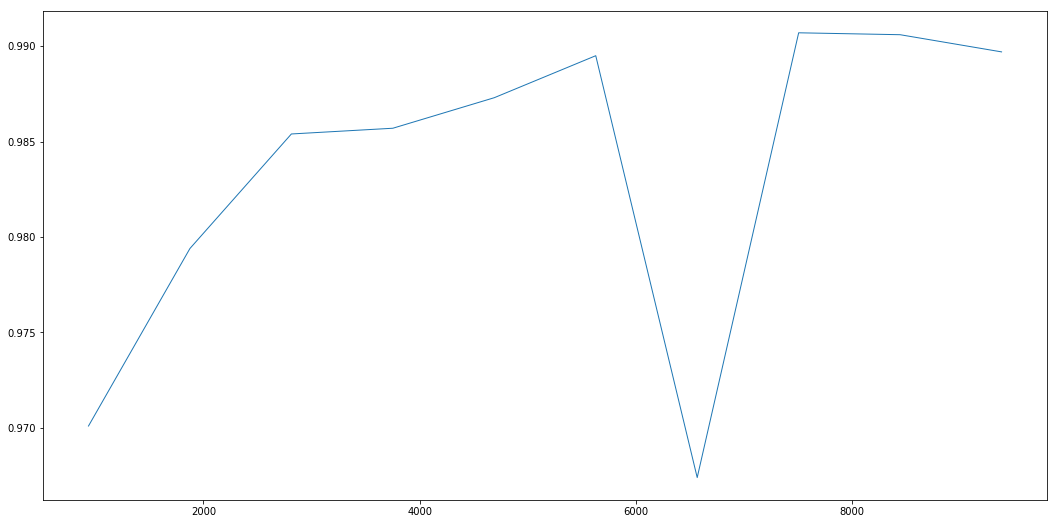

In [42]:
_, ax = plt.subplots(figsize=(18,9))

ln1 = a.sqlite.render_scalar(Scalars.accuracy, ax, sns.color_palette()[0])

In [58]:
cur = a.sqlite.conn.execute(f'SELECT * from indexed_scalars WHERE indicator = "{a.sqlite.get_key(Scalars.test_sample_loss)}"')

In [59]:
res = [c for c in cur]

In [60]:
len(res)

100000

In [69]:
steps = list({r[1] for r in res})
steps.sort()
steps_idx = {s: i for i, s in enumerate(steps)}
steps

[938, 1876, 2814, 3752, 4690, 5628, 6566, 7504, 8442, 9380]

In [96]:
table = np.zeros((len(steps), 10000), np.float)

In [97]:
for r in res:
    idx = steps_idx[r[1]]
    table[idx, r[2]] = r[3]

In [98]:
table.shape

(10, 10000)

In [102]:
losses = table[-1]

In [132]:
np.argsort(losses)[-10:]

array([2927, 9729, 1226, 9009,  449, 4176, 9770, 3422, 2654, 3520])

In [113]:
from torchvision import datasets, transforms
from lab.experiment.pytorch import Experiment
from lab import logger

exp = Experiment(name="test")
ds = datasets.MNIST(str(logger.get_data_path()),
                       train=False,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

(<matplotlib.image.AxesImage at 0x7f219a92ec50>, 7)

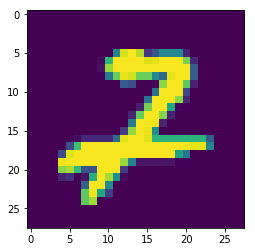

In [136]:
plt.imshow(ds[9009][0].squeeze()), ds[9009][1]

In [84]:
cur = conn.execute('SELECT MAX(step) FROM scalars')

In [85]:
for c in cur:
    print(c)

(1876,)


In [86]:
cur = conn.execute('''SELECT a.* FROM scalars AS a
            INNER JOIN (
                SELECT indicator, MAX(step) AS step 
                FROM scalars
                GROUP BY indicator
            ) b ON a.indicator = b.indicator AND a.step = b.step''')

In [87]:
for c in cur:
    print(c)

('model.conv1.weight.mean', 1876, 0.018370917066931725)
('model.conv1.weight.grad.mean', 1876, -0.0013952843146398664)
('model.conv1.bias.mean', 1876, 0.016558634117245674)
('model.conv1.bias.grad.mean', 1876, -0.00031752436188980937)
('model.conv2.weight.mean', 1876, -0.00010347135685151443)
('model.conv2.weight.grad.mean', 1876, -0.00017689727246761322)
('model.conv2.bias.mean', 1876, 0.005232199560850859)
('model.conv2.bias.grad.mean', 1876, 0.00010203290730714798)
('model.fc1.weight.mean', 1876, 0.00013659313844982535)
('model.fc1.weight.grad.mean', 1876, -3.2266973448713543e-06)
('model.fc1.bias.mean', 1876, 0.0014599027344956994)
('model.fc1.bias.grad.mean', 1876, -3.8176108319021296e-06)
('model.fc2.weight.mean', 1876, -0.00024156866129487753)
('model.fc2.weight.grad.mean', 1876, -1.4543533044530932e-09)
('model.fc2.bias.mean', 1876, -0.0009683696553111076)
('model.fc2.bias.grad.mean', 1876, -1.862645149230957e-09)
('train_loss.mean', 1876, 0.07672616839408875)
('test_loss.mean'

In [67]:
a.tb.load()

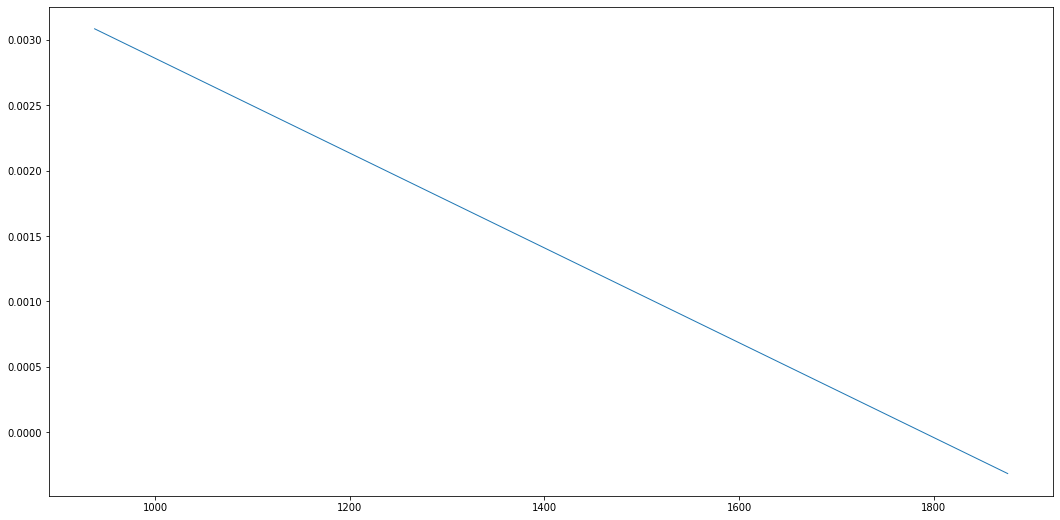

In [78]:
_, ax = plt.subplots(figsize=(18,9))

ln1 = a.tb.render_scalar(Scalars.model_conv1_bias_grad, ax, sns.color_palette()[0])

In [42]:
if 0:
    a.tb.event_acc.Tags()

In [43]:
if 0:
    logger.info(a.tensor())

In [25]:
e = a.tensor('accuracy/mean')[0]

In [28]:
e

TensorEvent(wall_time=1578115164.843276, step=938, tensor_proto=dtype: DT_FLOAT
tensor_shape {
}
tensor_content: "\007_x?"
)

In [35]:
import tensorflow as tf

In [36]:
tf.make_ndarray(e.tensor_proto)

array(0.9702, dtype=float32)

In [49]:
tf.make_ndarray(a.tensor('model/conv2/bias')[0].tensor_proto)

array([[-4.70585525e-02, -4.41074430e-02,  2.00000000e+00],
       [-4.41074430e-02, -4.11563334e-02,  1.00000000e+00],
       [-4.11563334e-02, -3.82052239e-02,  1.00000000e+00],
       [-3.82052239e-02, -3.52541144e-02,  0.00000000e+00],
       [-3.52541144e-02, -3.23030048e-02,  2.00000000e+00],
       [-3.23030048e-02, -2.93518953e-02,  0.00000000e+00],
       [-2.93518953e-02, -2.64007858e-02,  1.00000000e+00],
       [-2.64007858e-02, -2.34496762e-02,  0.00000000e+00],
       [-2.34496762e-02, -2.04985667e-02,  1.00000000e+00],
       [-2.04985667e-02, -1.75474572e-02,  3.00000000e+00],
       [-1.75474572e-02, -1.45963476e-02,  2.00000000e+00],
       [-1.45963476e-02, -1.16452381e-02,  4.00000000e+00],
       [-1.16452381e-02, -8.69412857e-03,  1.00000000e+00],
       [-8.69412857e-03, -5.74301903e-03,  2.00000000e+00],
       [-5.74301903e-03, -2.79190950e-03,  2.00000000e+00],
       [-2.79190950e-03,  1.59200033e-04,  2.00000000e+00],
       [ 1.59200033e-04,  3.11030957e-03